In [ ]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
# Direktori untuk dataset
train_dir = "fer2013/train"
test_dir = "fer2013/test"

Found 28709 images belonging to 7 classes.


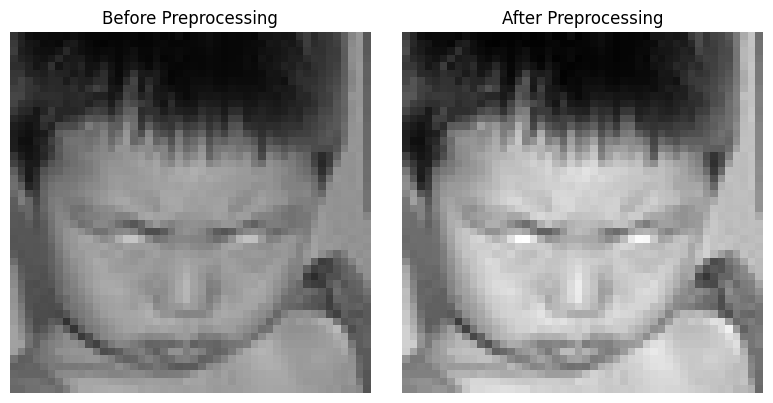

In [ ]:
# Buat ImageDataGenerator (preprocessing)
datagen = ImageDataGenerator(rescale=1./255)
gen = datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=1,
    shuffle=False
)

# Ambil nama kelas dan path ke salah satu file asli (before preprocessing)
first_class = os.listdir(train_dir)[0]
class_path = os.path.join(train_dir, first_class)
img_name = os.listdir(class_path)[0]
original_img_path = os.path.join(class_path, img_name)

# Load gambar asli (tanpa preprocessing)
img_before = cv2.imread(original_img_path)
img_before = cv2.cvtColor(img_before, cv2.COLOR_BGR2RGB)

# Ambil satu gambar setelah preprocessing dari generator
img_after = next(gen)[0][0]  # shape: (48, 48, 1)
img_after = np.squeeze(img_after)  # shape: (48, 48)

# Tampilkan side-by-side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_before)
plt.title("Before Preprocessing")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_after, cmap='gray')
plt.title("After Preprocessing")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Preprocessing dan augmentasi data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


# Dimensi gambar
img_size = (48, 48)

# Membaca data latih dengan augmentasi
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    subset='training',
    shuffle=True
)

# Menyimpan label ke dalam file JSON
with open("labels.json", "w") as f:
    json.dump(train_gen.class_indices, f)

# Membaca data validasi
val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    subset='validation',
    shuffle=True
)

Found 25841 images belonging to 7 classes.
Found 2868 images belonging to 7 classes.


In [12]:
# Membangun model CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 kelas emosi
])

# Menyusun model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback: EarlyStopping
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Melatih model
history = model.fit(
    train_gen, 
    validation_data=val_gen,
    epochs=50,
    callbacks=[earlystop]
)

# Menyimpan model yang sudah dilatih
model.save("expression_model.keras")

Epoch 1/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2348 - loss: 1.8210

C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


404/404 ━━━━━━━━━━━━━━━━━━━━ 37s 88ms/step - accuracy: 0.2349 - loss: 1.8209 - val_accuracy: 0.3002 - val_loss: 1.7252
Epoch 2/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.2983 - loss: 1.7283 - val_accuracy: 0.3619 - val_loss: 1.6356
Epoch 3/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 34s 85ms/step - accuracy: 0.3474 - loss: 1.6593 - val_accuracy: 0.3818 - val_loss: 1.5890
Epoch 4/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.3761 - loss: 1.5956 - val_accuracy: 0.4003 - val_loss: 1.5444
Epoch 5/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 33s 81ms/step - accuracy: 0.3845 - loss: 1.5730 - val_accuracy: 0.3989 - val_loss: 1.5429
Epoch 6/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step - accuracy: 0.4007 - loss: 1.5376 - val_accuracy: 0.4107 - val_loss: 1.5073
Epoch 7/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.4124 - loss: 1.5097 - val_accuracy: 0.4240 - val_loss: 1.4731
Epoch 8/50
404/404 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.4241 - loss: 1.4865 - val_accura

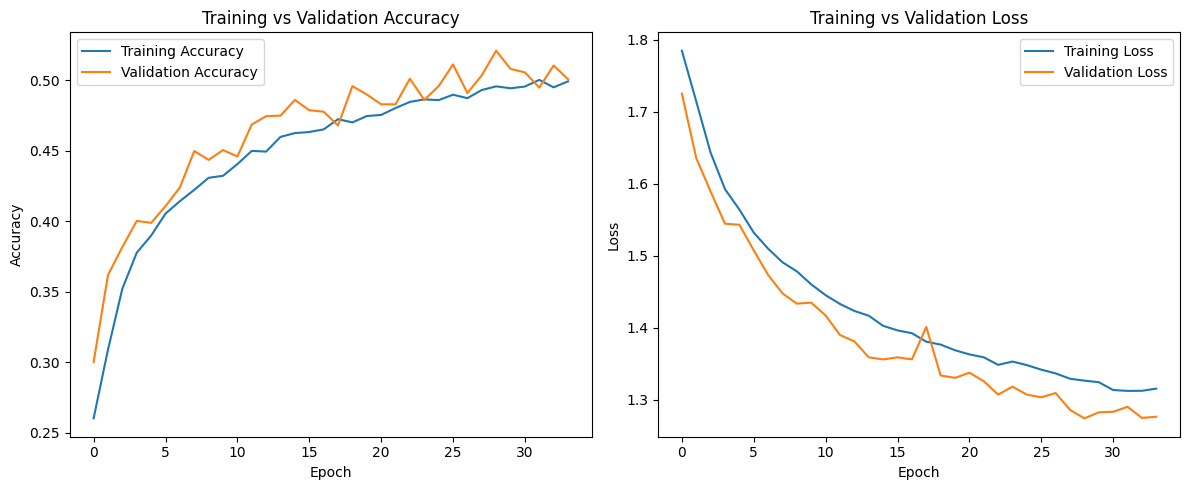

In [13]:
# Visualisasi akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()